In [1]:
import numpy as np
import time
import os
import argparse
import pickle
import theano, lasagne
import theano.tensor as T
from lasagne.layers import NonlinearityLayer, DenseLayer, DropoutLayer, LSTMLayer, ReshapeLayer, FlattenLayer
from lasagne.nonlinearities import softmax
from lasagne.layers.dnn import Pool2DDNNLayer as PoolLayer, BatchNormDNNLayer as BatchNormLayer
from matplotlib import pylab as plt
from ucf101_data import DataLoader
from resnet50 import Resnet50

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5110)


In [2]:
model_path = '/home/boris/Project/3rd_party/models/resnet/resnet50.pkl'
lr = 1e-2
layers = 'last'
step_size = 5000
max_iter = 10000
train_step = 100
val_step = 500
lrdec = 0.1
wdec = 5e-4
bs = 16  # batch_size

# temporal params
# TODO: fix data loader to train on longer sequences
time_steps = 25
stride = 1

plot = True
save = 1000
data_dir = '/home/boris/Project/data/videos/UCF101'  # dir with all frames
results_dir = 'results'

ApplyEyeMakeup : 101 samples
ApplyLipstick : 82 samples
Archery : 104 samples
BabyCrawling : 97 samples
BalanceBeam : 77 samples
BandMarching : 112 samples
BaseballPitch : 107 samples
Basketball : 99 samples
BasketballDunk : 94 samples
BenchPress : 112 samples
Biking : 96 samples
Billiards : 110 samples
BlowDryHair : 93 samples
BlowingCandles : 76 samples
BodyWeightSquats : 82 samples
Bowling : 112 samples
BoxingPunchingBag : 114 samples
BoxingSpeedBag : 97 samples
BreastStroke : 73 samples
BrushingTeeth : 95 samples
CleanAndJerk : 79 samples
CliffDiving : 99 samples
CricketBowling : 103 samples
CricketShot : 118 samples
CuttingInKitchen : 77 samples
Diving : 105 samples
Drumming : 116 samples
Fencing : 77 samples
FieldHockeyPenalty : 86 samples
FloorGymnastics : 89 samples
FrisbeeCatch : 89 samples
FrontCrawl : 100 samples
GolfSwing : 100 samples
Haircut : 97 samples
Hammering : 107 samples
HammerThrow : 105 samples
HandstandPushups : 100 samples
HandstandWalking : 77 samples
HeadMass

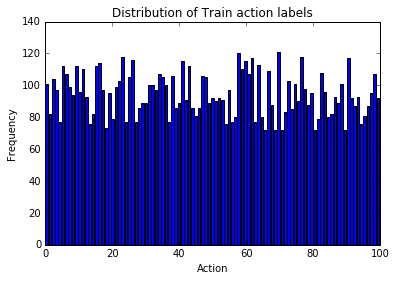

ApplyEyeMakeup : 44 samples
ApplyLipstick : 32 samples
Archery : 41 samples
BabyCrawling : 35 samples
BalanceBeam : 31 samples
BandMarching : 43 samples
BaseballPitch : 43 samples
Basketball : 35 samples
BasketballDunk : 37 samples
BenchPress : 48 samples
Biking : 38 samples
Billiards : 40 samples
BlowDryHair : 38 samples
BlowingCandles : 33 samples
BodyWeightSquats : 30 samples
Bowling : 43 samples
BoxingPunchingBag : 49 samples
BoxingSpeedBag : 37 samples
BreastStroke : 28 samples
BrushingTeeth : 36 samples
CleanAndJerk : 33 samples
CliffDiving : 39 samples
CricketBowling : 36 samples
CricketShot : 49 samples
CuttingInKitchen : 33 samples
Diving : 45 samples
Drumming : 45 samples
Fencing : 34 samples
FieldHockeyPenalty : 40 samples
FloorGymnastics : 36 samples
FrisbeeCatch : 37 samples
FrontCrawl : 37 samples
GolfSwing : 39 samples
Haircut : 33 samples
Hammering : 33 samples
HammerThrow : 45 samples
HandstandPushups : 28 samples
HandstandWalking : 34 samples
HeadMassage : 41 samples


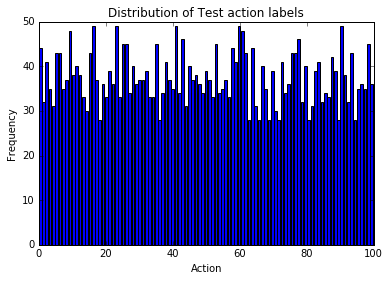

SPLIT=1: 9537 training samples, 3783 test samples, 101 classes


In [3]:
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

dloader = DataLoader(data_dir, shuffle_train=True)
frames_dir = dloader.data_dir + '/raw/'

In [4]:
##########################
### Define the network ###
##########################
input_var = T.tensor4('inputs')
model = Resnet50(input_var)
model.load(model_path)
#model.image_classify()
net = model.net
print(net['input'].output_shape)
last_layer = 'prob'
del net['fc1000']
print(net['pool5'].output_shape)
net['flat'] = FlattenLayer(net['pool5'])  # optional
print(net['flat'].output_shape)
net['lstm_reshape'] = ReshapeLayer(net['flat'], shape=(-1, time_steps, net['pool5'].output_shape[1]))
print(net['lstm_reshape'].output_shape)                            
net['lstm'] = LSTMLayer(net['lstm_reshape'], num_units=512, nonlinearity=lasagne.nonlinearities.tanh, only_return_final=True)
print(net['lstm'].output_shape)
net['fc'] = DenseLayer(net['lstm'], num_units=len(dloader.classes), nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc'], nonlinearity=softmax)

openning the .pkl file
model Resnet50 loaded
(None, 3, 224, 224)
(None, 2048, 1, 1)
(None, 2048)
(None, 25, 2048)
(None, 512)


In [5]:
# Remove tags to skip updating some layers
if layers != 'all':
    for layer in net.items():
        if (layers == 'last' and (layer[0] == 'lstm' or layer[0] == 'bnorm' or layer[0] == 'fc')):
            print(layer[0] + ' - trainable')
            continue
        try:
            for p in layer[1].params:
                if 'trainable' in layer[1].params[p]:
                    layer[1].params[p].remove("trainable")
        except Exception as e:
            print(layer[0],layer[1],e.message)
            continue

lstm - trainable
fc - trainable


In [6]:
print('building the network...')
target_var = T.ivector('targets')
prediction_val = T.clip(lasagne.layers.get_output(net[last_layer], deterministic=True), 1e-10, 1.0 - 1e-10)
loss_val = lasagne.objectives.categorical_crossentropy(prediction_val, target_var)
val_fn = theano.function([input_var, target_var], [loss_val, prediction_val])

prediction_train = T.clip(lasagne.layers.get_output(net[last_layer]), 1e-10, 1.0 - 1e-10)
loss_train_all = lasagne.objectives.categorical_crossentropy(prediction_train, target_var)
loss_train = loss_train_all.mean()
weightsl2 = lasagne.regularization.regularize_network_params(net[last_layer], lasagne.regularization.l2)
loss_train_all = loss_train + wdec * weightsl2

lr_var = theano.shared(np.array(lr, dtype=theano.config.floatX))
params = lasagne.layers.get_all_params(net[last_layer], trainable=True)
print('%d trainable parameters (like weights W or bias b) ' % len(params))
print('compiling updates...')
updates = lasagne.updates.nesterov_momentum(loss_train_all, params, learning_rate=lr_var, momentum=0.9)
print('compiling train_fn...')
train_fn = theano.function([input_var, target_var], [loss_train, loss_train_all, prediction_train], updates=updates)
print('done')

n_val = 1000
train_data = (dloader.train_videos[:-n_val], dloader.train_labels[:-n_val])
val_data = (dloader.train_videos[-n_val:], dloader.train_labels[-n_val:])

building the network...
17 trainable parameters (like weights W or bias b) 
compiling updates...
compiling train_fn...
done


it (batch) 1, val time 127.131, val loss 4.7565, val error (videos) 0.9900


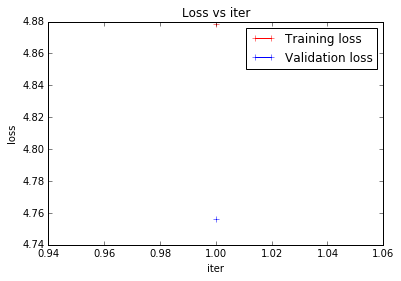

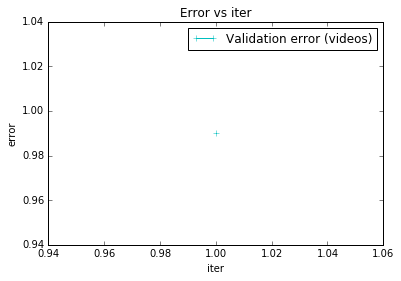

saving results
it 100 (batch=16), lr 1.0e-02, train loss 3.55 (with weights 54.90), load data/iter 0.81, train time/iter 2.16
it 200 (batch=16), lr 1.0e-02, train loss 3.01 (with weights 53.87), load data/iter 0.83, train time/iter 2.16
it 300 (batch=16), lr 1.0e-02, train loss 2.79 (with weights 53.18), load data/iter 0.76, train time/iter 2.15
it 400 (batch=16), lr 1.0e-02, train loss 3.08 (with weights 53.00), load data/iter 0.81, train time/iter 2.15
it 500 (batch=16), lr 1.0e-02, train loss 2.06 (with weights 51.53), load data/iter 0.83, train time/iter 2.15
it (batch) 500, val time 130.944, val loss 1.7696, val error (videos) 0.4120


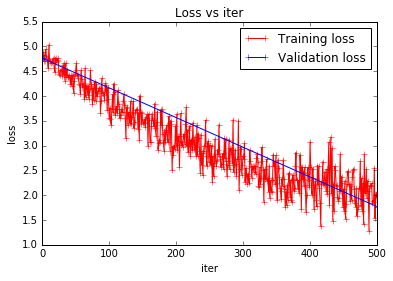

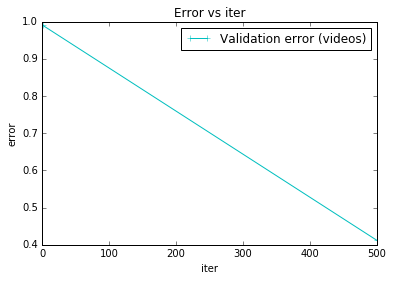

saving results
it 600 (batch=16), lr 1.0e-02, train loss 1.31 (with weights 50.34), load data/iter 0.82, train time/iter 2.14
it 700 (batch=16), lr 1.0e-02, train loss 2.43 (with weights 51.04), load data/iter 0.83, train time/iter 2.16
it 800 (batch=16), lr 1.0e-02, train loss 1.52 (with weights 49.71), load data/iter 0.87, train time/iter 2.15
it 900 (batch=16), lr 1.0e-02, train loss 1.49 (with weights 49.26), load data/iter 0.87, train time/iter 2.15
it 1000 (batch=16), lr 1.0e-02, train loss 1.59 (with weights 48.95), load data/iter 0.86, train time/iter 2.15
it (batch) 1000, val time 133.620, val loss 1.3908, val error (videos) 0.3450


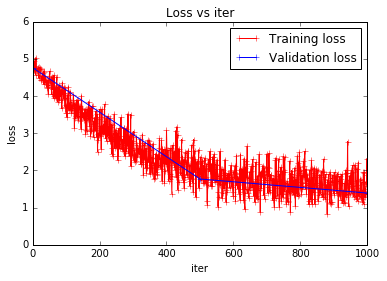

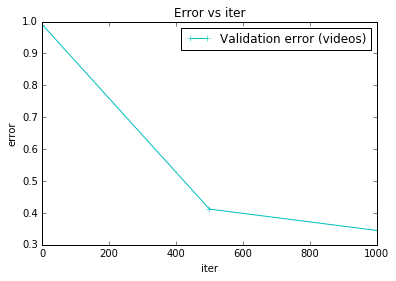

saving results
saving model
it 1100 (batch=16), lr 1.0e-02, train loss 1.37 (with weights 48.33), load data/iter 0.83, train time/iter 2.14
it 1200 (batch=16), lr 1.0e-02, train loss 1.34 (with weights 47.91), load data/iter 0.87, train time/iter 2.16
it 1300 (batch=16), lr 1.0e-02, train loss 1.39 (with weights 47.57), load data/iter 0.86, train time/iter 2.16
it 1400 (batch=16), lr 1.0e-02, train loss 1.07 (with weights 46.87), load data/iter 0.82, train time/iter 2.15
it 1500 (batch=16), lr 1.0e-02, train loss 1.30 (with weights 46.72), load data/iter 0.86, train time/iter 2.16
it (batch) 1500, val time 131.593, val loss 1.0548, val error (videos) 0.2710


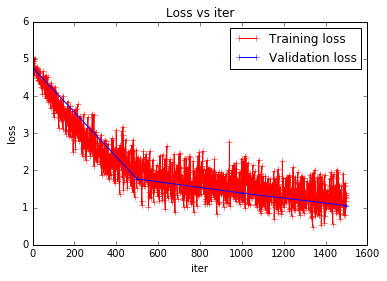

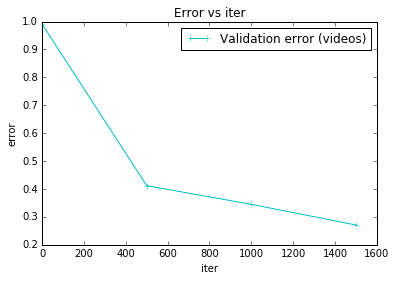

saving results
it 1600 (batch=16), lr 1.0e-02, train loss 2.19 (with weights 47.25), load data/iter 0.83, train time/iter 2.15
it 1700 (batch=16), lr 1.0e-02, train loss 1.11 (with weights 45.81), load data/iter 0.83, train time/iter 2.15
it 1800 (batch=16), lr 1.0e-02, train loss 1.36 (with weights 45.71), load data/iter 0.84, train time/iter 2.15
it 1900 (batch=16), lr 1.0e-02, train loss 1.39 (with weights 45.39), load data/iter 0.82, train time/iter 2.15
it 2000 (batch=16), lr 1.0e-02, train loss 1.40 (with weights 45.06), load data/iter 0.85, train time/iter 2.15
it (batch) 2000, val time 131.227, val loss 0.8947, val error (videos) 0.2310


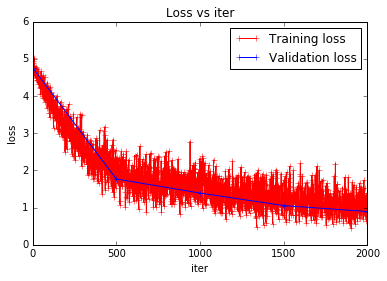

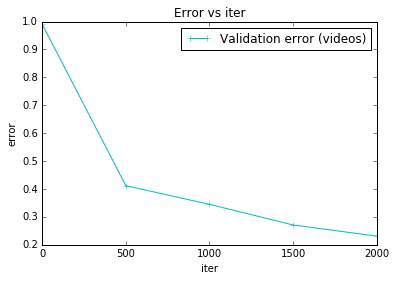

saving results
saving model
it 2100 (batch=16), lr 1.0e-02, train loss 0.80 (with weights 44.13), load data/iter 0.80, train time/iter 2.15
it 2200 (batch=16), lr 1.0e-02, train loss 1.10 (with weights 44.10), load data/iter 0.86, train time/iter 2.15
it 2300 (batch=16), lr 1.0e-02, train loss 0.81 (with weights 43.48), load data/iter 0.86, train time/iter 2.15
it 2400 (batch=16), lr 1.0e-02, train loss 1.17 (with weights 43.53), load data/iter 0.83, train time/iter 2.15
it 2500 (batch=16), lr 1.0e-02, train loss 0.41 (with weights 42.46), load data/iter 0.83, train time/iter 2.15
it (batch) 2500, val time 133.049, val loss 0.7784, val error (videos) 0.1990


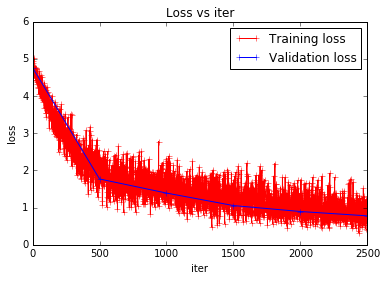

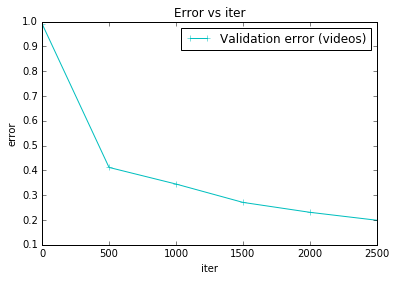

saving results
it 2600 (batch=16), lr 1.0e-02, train loss 0.55 (with weights 42.29), load data/iter 0.83, train time/iter 2.15
it 2700 (batch=16), lr 1.0e-02, train loss 0.54 (with weights 41.98), load data/iter 0.83, train time/iter 2.14
it 2800 (batch=16), lr 1.0e-02, train loss 0.68 (with weights 41.82), load data/iter 0.85, train time/iter 2.15
it 2900 (batch=16), lr 1.0e-02, train loss 0.92 (with weights 41.77), load data/iter 0.87, train time/iter 2.15
it 3000 (batch=16), lr 1.0e-02, train loss 0.72 (with weights 41.29), load data/iter 0.84, train time/iter 2.15
it (batch) 3000, val time 131.200, val loss 0.6948, val error (videos) 0.1860


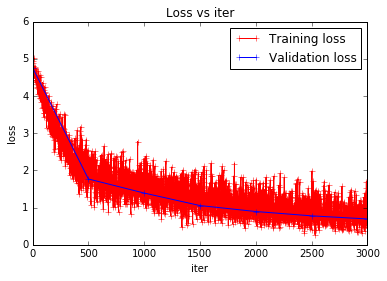

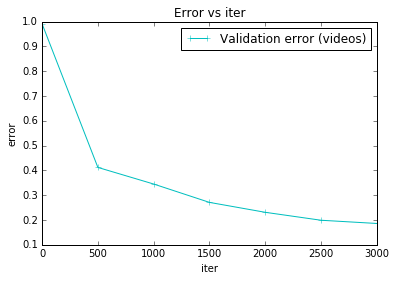

saving results
saving model
it 3100 (batch=16), lr 1.0e-02, train loss 0.75 (with weights 41.04), load data/iter 0.84, train time/iter 2.15
it 3200 (batch=16), lr 1.0e-02, train loss 1.42 (with weights 41.45), load data/iter 0.84, train time/iter 2.15
it 3300 (batch=16), lr 1.0e-02, train loss 0.56 (with weights 40.32), load data/iter 0.84, train time/iter 2.14
it 3400 (batch=16), lr 1.0e-02, train loss 0.55 (with weights 40.04), load data/iter 0.88, train time/iter 2.15
it 3500 (batch=16), lr 1.0e-02, train loss 0.32 (with weights 39.55), load data/iter 0.83, train time/iter 2.15
it (batch) 3500, val time 131.846, val loss 0.5493, val error (videos) 0.1360


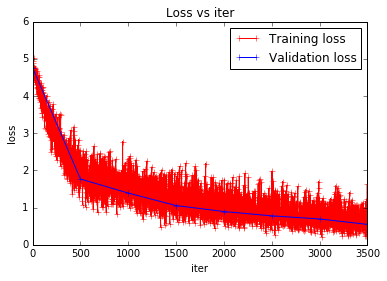

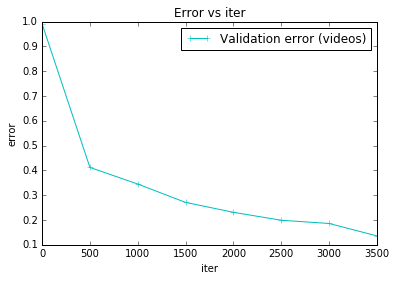

saving results
it 3600 (batch=16), lr 1.0e-02, train loss 0.55 (with weights 39.53), load data/iter 0.83, train time/iter 2.15
it 3700 (batch=16), lr 1.0e-02, train loss 0.61 (with weights 39.34), load data/iter 0.85, train time/iter 2.16
it 3800 (batch=16), lr 1.0e-02, train loss 0.41 (with weights 38.89), load data/iter 0.84, train time/iter 2.15
it 3900 (batch=16), lr 1.0e-02, train loss 0.66 (with weights 38.90), load data/iter 0.85, train time/iter 2.15
it 4000 (batch=16), lr 1.0e-02, train loss 0.27 (with weights 38.27), load data/iter 0.85, train time/iter 2.15
it (batch) 4000, val time 130.288, val loss 0.4922, val error (videos) 0.1170


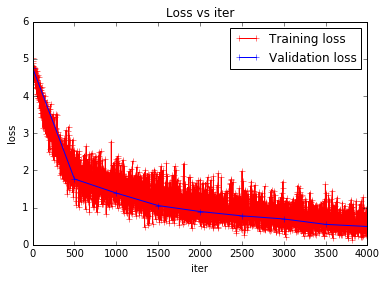

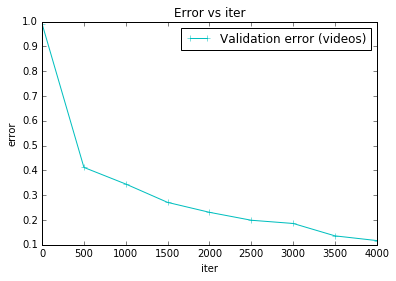

saving results
saving model
it 4100 (batch=16), lr 1.0e-02, train loss 0.99 (with weights 38.76), load data/iter 0.83, train time/iter 2.15
it 4200 (batch=16), lr 1.0e-02, train loss 0.83 (with weights 38.37), load data/iter 0.82, train time/iter 2.15
it 4300 (batch=16), lr 1.0e-02, train loss 0.64 (with weights 37.96), load data/iter 0.82, train time/iter 2.14
it 4400 (batch=16), lr 1.0e-02, train loss 0.43 (with weights 37.53), load data/iter 0.82, train time/iter 2.15
it 4500 (batch=16), lr 1.0e-02, train loss 0.26 (with weights 37.15), load data/iter 0.82, train time/iter 2.15
it (batch) 4500, val time 129.292, val loss 0.4231, val error (videos) 0.1110


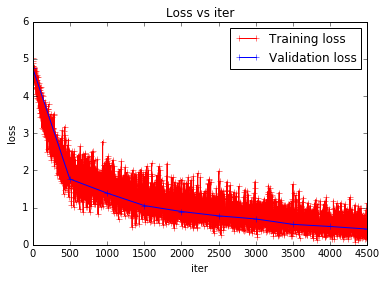

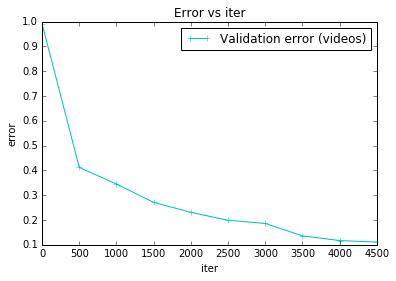

saving results
it 4600 (batch=16), lr 1.0e-02, train loss 0.59 (with weights 37.27), load data/iter 0.79, train time/iter 2.15
it 4700 (batch=16), lr 1.0e-02, train loss 0.42 (with weights 36.89), load data/iter 0.80, train time/iter 2.15
it 4800 (batch=16), lr 1.0e-02, train loss 0.30 (with weights 36.56), load data/iter 0.80, train time/iter 2.15
it 4900 (batch=16), lr 1.0e-02, train loss 0.51 (with weights 36.57), load data/iter 0.81, train time/iter 2.14
lr = 0.0010000
it 5000 (batch=16), lr 1.0e-03, train loss 0.22 (with weights 36.09), load data/iter 0.82, train time/iter 2.15
it (batch) 5000, val time 128.982, val loss 0.3805, val error (videos) 0.0950


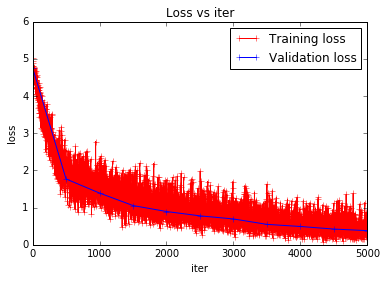

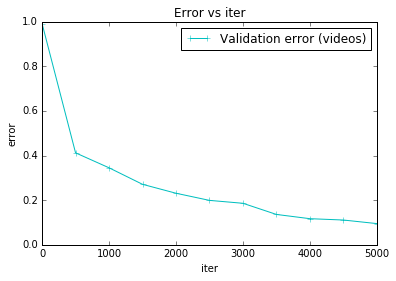

saving results
saving model
it 5100 (batch=16), lr 1.0e-03, train loss 0.15 (with weights 35.99), load data/iter 0.80, train time/iter 2.15
it 5200 (batch=16), lr 1.0e-03, train loss 0.56 (with weights 36.38), load data/iter 0.82, train time/iter 2.16
it 5300 (batch=16), lr 1.0e-03, train loss 0.28 (with weights 36.08), load data/iter 0.81, train time/iter 2.15
it 5400 (batch=16), lr 1.0e-03, train loss 0.39 (with weights 36.17), load data/iter 0.81, train time/iter 2.14
it 5500 (batch=16), lr 1.0e-03, train loss 0.21 (with weights 35.96), load data/iter 0.80, train time/iter 2.15
it (batch) 5500, val time 131.387, val loss 0.3194, val error (videos) 0.0770


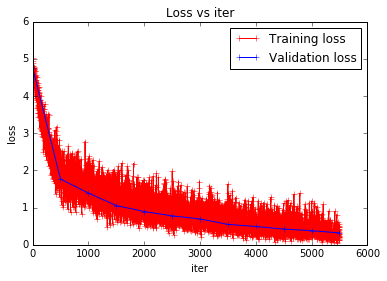

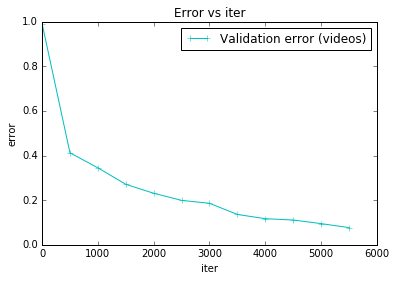

saving results
it 5600 (batch=16), lr 1.0e-03, train loss 0.65 (with weights 36.38), load data/iter 0.84, train time/iter 2.15
it 5700 (batch=16), lr 1.0e-03, train loss 0.16 (with weights 35.88), load data/iter 0.86, train time/iter 2.15
it 5800 (batch=16), lr 1.0e-03, train loss 0.37 (with weights 36.07), load data/iter 0.84, train time/iter 2.15
it 5900 (batch=16), lr 1.0e-03, train loss 0.41 (with weights 36.08), load data/iter 0.83, train time/iter 2.14
it 6000 (batch=16), lr 1.0e-03, train loss 0.28 (with weights 35.94), load data/iter 0.84, train time/iter 2.15
it (batch) 6000, val time 132.424, val loss 0.2911, val error (videos) 0.0790


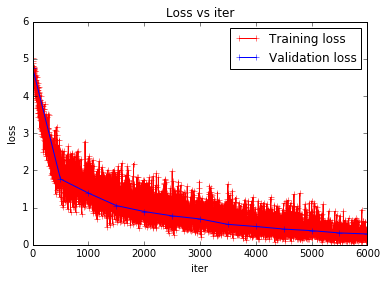

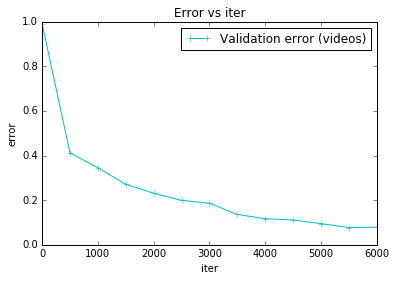

saving results
saving model
it 6100 (batch=16), lr 1.0e-03, train loss 0.37 (with weights 36.01), load data/iter 0.79, train time/iter 2.15
it 6200 (batch=16), lr 1.0e-03, train loss 0.07 (with weights 35.69), load data/iter 0.80, train time/iter 2.15
it 6300 (batch=16), lr 1.0e-03, train loss 0.38 (with weights 35.98), load data/iter 0.82, train time/iter 2.15
it 6400 (batch=16), lr 1.0e-03, train loss 0.38 (with weights 35.96), load data/iter 0.82, train time/iter 2.15
it 6500 (batch=16), lr 1.0e-03, train loss 0.24 (with weights 35.79), load data/iter 0.80, train time/iter 2.14
it (batch) 6500, val time 129.239, val loss 0.2814, val error (videos) 0.0660


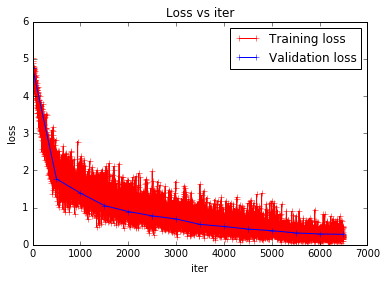

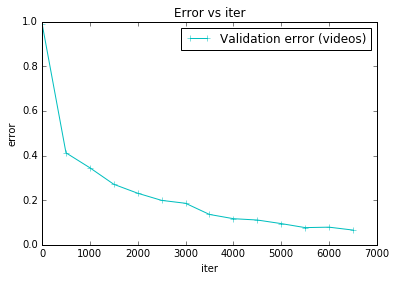

saving results
it 6600 (batch=16), lr 1.0e-03, train loss 0.08 (with weights 35.62), load data/iter 0.79, train time/iter 2.15
it 6700 (batch=16), lr 1.0e-03, train loss 0.18 (with weights 35.70), load data/iter 0.79, train time/iter 2.15
it 6800 (batch=16), lr 1.0e-03, train loss 0.16 (with weights 35.66), load data/iter 0.82, train time/iter 2.15
it 6900 (batch=16), lr 1.0e-03, train loss 0.24 (with weights 35.72), load data/iter 0.81, train time/iter 2.15
it 7000 (batch=16), lr 1.0e-03, train loss 0.26 (with weights 35.72), load data/iter 0.80, train time/iter 2.14
it (batch) 7000, val time 128.122, val loss 0.2675, val error (videos) 0.0690


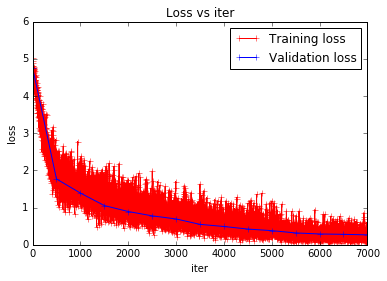

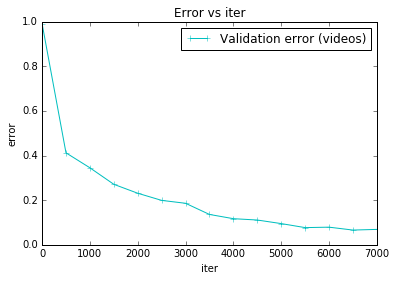

saving results
saving model
it 7100 (batch=16), lr 1.0e-03, train loss 0.21 (with weights 35.65), load data/iter 0.85, train time/iter 2.15
it 7200 (batch=16), lr 1.0e-03, train loss 0.29 (with weights 35.71), load data/iter 0.84, train time/iter 2.15
it 7300 (batch=16), lr 1.0e-03, train loss 0.13 (with weights 35.53), load data/iter 0.83, train time/iter 2.15
it 7400 (batch=16), lr 1.0e-03, train loss 0.10 (with weights 35.48), load data/iter 0.83, train time/iter 2.15
it 7500 (batch=16), lr 1.0e-03, train loss 0.84 (with weights 36.20), load data/iter 0.84, train time/iter 2.14
it (batch) 7500, val time 131.727, val loss 0.2631, val error (videos) 0.0690


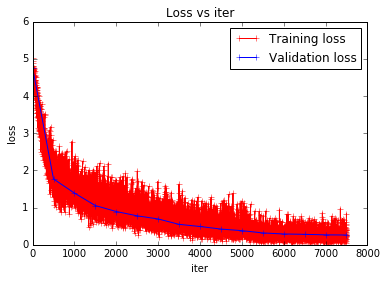

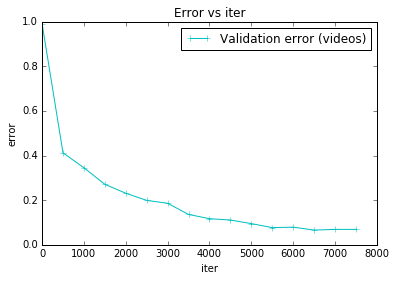

saving results
it 7600 (batch=16), lr 1.0e-03, train loss 0.51 (with weights 35.86), load data/iter 0.84, train time/iter 2.15
it 7700 (batch=16), lr 1.0e-03, train loss 0.24 (with weights 35.56), load data/iter 0.82, train time/iter 2.15
it 7800 (batch=16), lr 1.0e-03, train loss 0.08 (with weights 35.39), load data/iter 0.84, train time/iter 2.15
it 7900 (batch=16), lr 1.0e-03, train loss 0.13 (with weights 35.41), load data/iter 0.83, train time/iter 2.15
it 8000 (batch=16), lr 1.0e-03, train loss 0.18 (with weights 35.45), load data/iter 0.81, train time/iter 2.15
it (batch) 8000, val time 131.941, val loss 0.2477, val error (videos) 0.0660


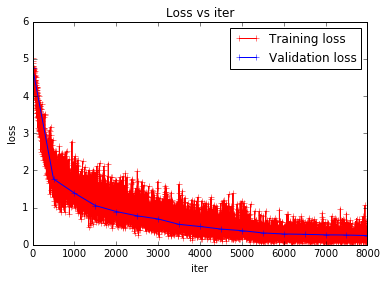

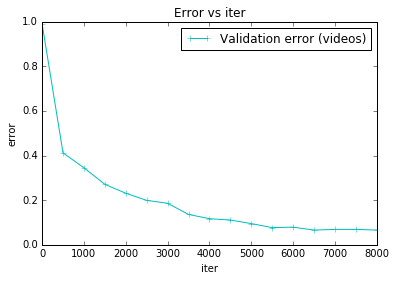

saving results
saving model
it 8100 (batch=16), lr 1.0e-03, train loss 0.31 (with weights 35.56), load data/iter 0.85, train time/iter 2.14
it 8200 (batch=16), lr 1.0e-03, train loss 0.26 (with weights 35.49), load data/iter 0.86, train time/iter 2.15
it 8300 (batch=16), lr 1.0e-03, train loss 0.32 (with weights 35.53), load data/iter 0.86, train time/iter 2.15
it 8400 (batch=16), lr 1.0e-03, train loss 0.50 (with weights 35.69), load data/iter 0.86, train time/iter 2.15
it 8500 (batch=16), lr 1.0e-03, train loss 0.13 (with weights 35.31), load data/iter 0.86, train time/iter 2.15
it (batch) 8500, val time 135.082, val loss 0.2466, val error (videos) 0.0580


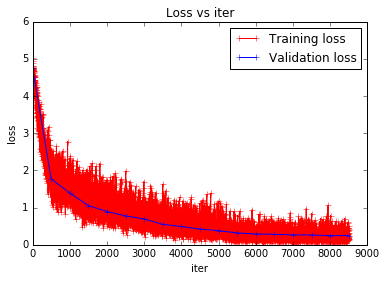

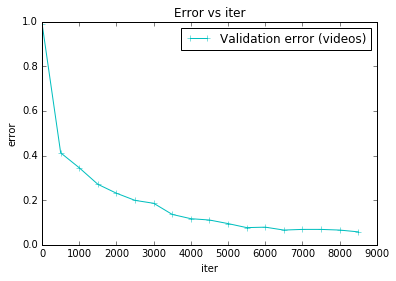

saving results
it 8600 (batch=16), lr 1.0e-03, train loss 0.14 (with weights 35.30), load data/iter 0.83, train time/iter 2.14
it 8700 (batch=16), lr 1.0e-03, train loss 0.87 (with weights 36.00), load data/iter 0.84, train time/iter 2.15
it 8800 (batch=16), lr 1.0e-03, train loss 0.28 (with weights 35.40), load data/iter 0.83, train time/iter 2.15
it 8900 (batch=16), lr 1.0e-03, train loss 0.68 (with weights 35.78), load data/iter 0.84, train time/iter 2.15
it 9000 (batch=16), lr 1.0e-03, train loss 0.33 (with weights 35.41), load data/iter 0.84, train time/iter 2.15
it (batch) 9000, val time 131.572, val loss 0.2475, val error (videos) 0.0620


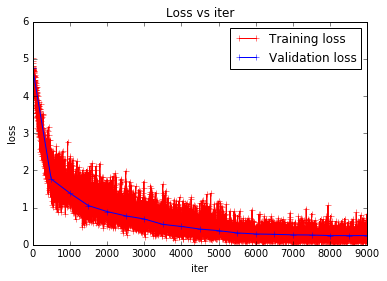

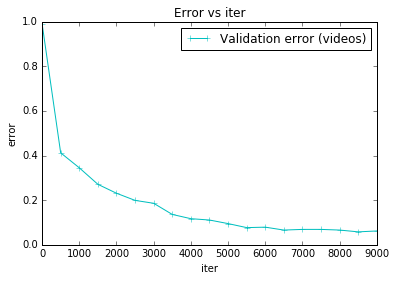

saving results
saving model
it 9100 (batch=16), lr 1.0e-03, train loss 0.12 (with weights 35.18), load data/iter 0.84, train time/iter 2.14
it 9200 (batch=16), lr 1.0e-03, train loss 0.08 (with weights 35.12), load data/iter 0.86, train time/iter 2.15
it 9300 (batch=16), lr 1.0e-03, train loss 0.26 (with weights 35.28), load data/iter 0.86, train time/iter 2.15
it 9400 (batch=16), lr 1.0e-03, train loss 0.25 (with weights 35.25), load data/iter 0.87, train time/iter 2.15
it 9500 (batch=16), lr 1.0e-03, train loss 0.17 (with weights 35.16), load data/iter 0.86, train time/iter 2.14
it (batch) 9500, val time 134.068, val loss 0.2328, val error (videos) 0.0540


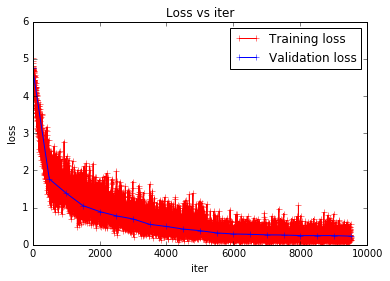

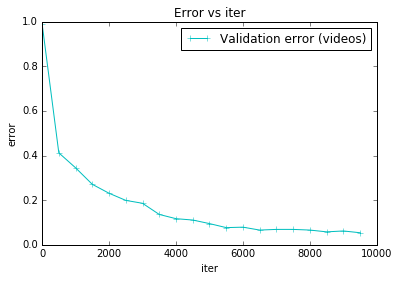

saving results
it 9600 (batch=16), lr 1.0e-03, train loss 0.29 (with weights 35.25), load data/iter 0.84, train time/iter 2.15
it 9700 (batch=16), lr 1.0e-03, train loss 0.08 (with weights 35.03), load data/iter 0.83, train time/iter 2.14
it 9800 (batch=16), lr 1.0e-03, train loss 0.31 (with weights 35.24), load data/iter 0.83, train time/iter 2.15
it 9900 (batch=16), lr 1.0e-03, train loss 0.13 (with weights 35.04), load data/iter 0.82, train time/iter 2.15
lr = 0.0001000
it 10000 (batch=16), lr 1.0e-04, train loss 0.10 (with weights 35.00), load data/iter 0.81, train time/iter 2.15
it (batch) 10000, val time 129.021, val loss 0.2191, val error (videos) 0.0530


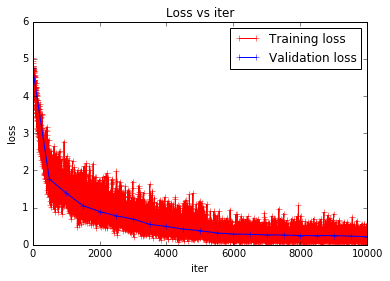

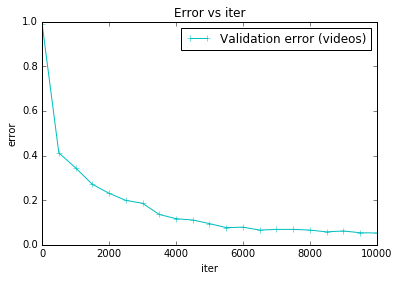

saving results
saving model


In [7]:
################
### TRAINING ###
################

loss_train_vs_iter, loss_val_vs_iter, err_val_videos_vs_iter = [],[],[]
data_load_time, train_iter_time = 0, 0
train_iter = dloader.get_batch_videos(train_data[0], train_data[1], bs)
it = 1
while it <= max_iter:
    
    if it % step_size == 0:
        lr_var.set_value(lr_var.get_value() * np.float32(lrdec))
        print('lr = %1.7f' % lr_var.get_value())            

    try:
        batch = train_iter.next()
    except StopIteration:
        ind = np.random.permutation(len(train_data[1]))
        train_data = ([train_data[0][i] for i in ind], train_data[1][ind])
        train_iter = dloader.get_batch_videos(train_data[0], train_data[1], bs)
        batch = train_iter.next()
    
    start = time.time()
    frames, ids = dloader.get_frames_rnn(frames_dir, batch[0], model.MEAN_BGR, True, STRIDE=stride, N_FRAMES=time_steps)
    data_load_time += time.time() - start
    start = time.time()
    loss, loss_plus_weight, prediction = train_fn(frames, batch[1]) # update weights, make predictions for each frame
    train_iter_time += time.time() - start
    loss_train_vs_iter.append((it,loss,loss_plus_weight))
    if it % min((val_step,train_step)) == 0:
        print('it %d (batch=%d), lr %.1e, train loss %.2f (with weights %.2f), load data/iter %.2f, train time/iter %.2f' % 
              (it, len(batch[1]), lr_var.get_value(), loss, loss_plus_weight, data_load_time/train_step, train_iter_time/train_step))
        data_load_time, train_iter_time = 0, 0
     
    ##################
    ### VALIDATION ###
    ##################
    if val_step > 0 and (it % val_step == 0 or it <= 1):
        start = time.time()
        val_loss, val_predictions, val_predictions_videos, frame_labels = [],[],[],[]
        for batch in dloader.get_batch_videos(val_data[0], val_data[1], bs):
            frames, _ = dloader.get_frames_rnn(frames_dir, batch[0], model.MEAN_BGR, False, STRIDE=stride, N_FRAMES=time_steps)
            loss, prediction = val_fn(frames, batch[1]) # predict labels for each frame
            val_loss.append(loss)
            val_predictions_videos.append(prediction) # get labels for each video
        
        loss_val_vs_iter.append((it,np.mean(np.concatenate(val_loss))))
        val_predictions_videos = np.concatenate(val_predictions_videos).reshape(-1,len(dloader.classes))
        val_err_videos = 1 - np.mean(np.equal(np.argmax(val_predictions_videos, axis=1), val_data[1]))
        err_val_videos_vs_iter.append((it,val_err_videos))
        print('it (batch) %d, val time %.3f, val loss %.4f, val error (videos) %.4f' % 
        (it, time.time() - start, loss_val_vs_iter[-1][1], val_err_videos))
        
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.set_xlabel('iter')
            ax.set_ylabel('loss')
            ax.set_title('Loss vs iter')
            plt.plot([t[0] for t in loss_train_vs_iter], [t[1] for t in loss_train_vs_iter],'r-+', label="Training loss")
            #plt.plot([t[0] for t in loss_train_vs_iter], [t[2] for t in loss_train_vs_iter],'r-+', label="Training loss with weights")
            plt.plot([t[0] for t in loss_val_vs_iter], [t[1] for t in loss_val_vs_iter],'b-+', label="Validation loss")
            plt.legend(loc='upper right')
            plt.savefig('%s/loss_vs_iter.png' % results_dir, dpi=fig.dpi)
            plt.show()
            
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.set_xlabel('iter')
            ax.set_ylabel('error')
            ax.set_title('Error vs iter')
            #plt.plot([t[0] for t in err_val_vs_iter], [t[1] for t in err_val_vs_iter],'g--', label="Training error (videos)")
            plt.plot([t[0] for t in err_val_videos_vs_iter], [t[1] for t in err_val_videos_vs_iter],'c-+', label="Validation error (videos)")
            plt.legend(loc='upper right')
            plt.savefig('%s/error_vs_iter.png' % results_dir, dpi=fig.dpi)
            plt.show()
        
        print('saving results')
        np.save('%s/losses_errors_labels' % results_dir, (loss_train_vs_iter, loss_val_vs_iter, 
                                                          err_val_videos_vs_iter))

    if it % save == 0:
        print('saving model')
        values = lasagne.layers.get_all_param_values(net[last_layer])
        with open('%s/snapshot_%d.pkl' % (results_dir,it) , 'w') as f:
            pickle.dump(values, f, protocol=pickle.HIGHEST_PROTOCOL)
        del values
        
    it += 1    

In [8]:
# Rebuilding the LSTM part to easier test on videos of different length
print(net['flat'].output_shape)
net['lstm_reshape'] = ReshapeLayer(net['flat'], shape=(1, -1, net['pool5'].output_shape[1]))
print(net['lstm_reshape'].output_shape)
net['lstm'].input_layers[0] = net['lstm_reshape']
print(net['lstm'].output_shape)
# rebuild the graph
prediction_val = T.clip(lasagne.layers.get_output(net[last_layer], deterministic=True), 1e-10, 1.0 - 1e-10)
loss_val = lasagne.objectives.categorical_crossentropy(prediction_val, target_var)
val_fn = theano.function([input_var, target_var], [loss_val, prediction_val])

(None, 2048)
(1, None, 2048)
(None, 512)


In [12]:
time_steps = 75 # max number of frames/video to process
bs = 16
print('Testing performance of the trained model with stride=%d, time_steps=%d' % (stride, time_steps))
start = time.time()
test_loss_videos, test_predictions_videos = [],[]
for batch in dloader.get_batch_videos(dloader.test_videos, dloader.test_labels, bs):
    samples, labels = dloader.get_frames_val(frames_dir, batch[0], model.MEAN_BGR, batch[1], STRIDE=stride, N_FRAMES=time_steps)
    for f,_ in enumerate(samples):
        loss, prediction = val_fn(samples[f], labels[f]) # predict labels for each frame
        if samples[f].shape[0] < time_steps:
            print(samples[f].shape, len(labels[f]), np.argmax(prediction), labels[f][0], loss)
        test_loss_videos.append(loss)
        test_predictions_videos.append(prediction) # get labels for each video
    print('video %d/%d' % (len(test_loss_videos), len(dloader.test_videos)))

Testing performance of the trained model with stride=1, time_steps=75
video 16/3783
video 32/3783
video 48/3783
video 64/3783
video 80/3783
video 96/3783
((51, 3, 224, 224), 51, 82, 2, array([ 6.50464201], dtype=float32))
video 112/3783
((72, 3, 224, 224), 72, 2, 2, array([ 1.07808661], dtype=float32))
((51, 3, 224, 224), 51, 5, 2, array([ 2.00836873], dtype=float32))
((51, 3, 224, 224), 51, 2, 2, array([ 1.10351086], dtype=float32))
((64, 3, 224, 224), 64, 79, 2, array([ 2.54618883], dtype=float32))
((67, 3, 224, 224), 67, 5, 2, array([ 2.23212981], dtype=float32))
video 128/3783
video 144/3783
((60, 3, 224, 224), 60, 4, 4, array([ 0.4791519], dtype=float32))
video 160/3783
video 176/3783
video 192/3783
video 208/3783
((47, 3, 224, 224), 47, 5, 5, array([ 0.05077237], dtype=float32))
((65, 3, 224, 224), 65, 5, 5, array([ 0.05251683], dtype=float32))
((62, 3, 224, 224), 62, 5, 5, array([ 0.00211026], dtype=float32))
((68, 3, 224, 224), 68, 5, 5, array([ 0.01330848], dtype=float32))
((7

((71, 3, 224, 224), 71, 22, 23, array([ 4.71041584], dtype=float32))
video 880/3783
video 896/3783
((56, 3, 224, 224), 56, 23, 23, array([ 0.12632076], dtype=float32))
((64, 3, 224, 224), 64, 23, 23, array([ 0.14267954], dtype=float32))
((57, 3, 224, 224), 57, 23, 23, array([ 0.12504688], dtype=float32))
((56, 3, 224, 224), 56, 23, 23, array([ 0.14170328], dtype=float32))
((65, 3, 224, 224), 65, 23, 23, array([ 0.22032672], dtype=float32))
((66, 3, 224, 224), 66, 23, 23, array([ 0.05311384], dtype=float32))
video 912/3783
video 928/3783
video 944/3783
((64, 3, 224, 224), 64, 24, 24, array([ 0.00832208], dtype=float32))
((62, 3, 224, 224), 62, 24, 24, array([ 0.9230907], dtype=float32))
video 960/3783
video 976/3783
((60, 3, 224, 224), 60, 25, 25, array([ 0.13583526], dtype=float32))
video 992/3783
video 1008/3783
video 1024/3783
video 1040/3783
video 1056/3783
video 1072/3783
video 1088/3783
((34, 3, 224, 224), 34, 39, 28, array([ 0.98443508], dtype=float32))
((70, 3, 224, 224), 70, 44

((70, 3, 224, 224), 70, 78, 78, array([ 1.29909444], dtype=float32))
((66, 3, 224, 224), 66, 78, 78, array([ 1.63353395], dtype=float32))
video 2960/3783
((73, 3, 224, 224), 73, 78, 78, array([ 0.20469069], dtype=float32))
((67, 3, 224, 224), 67, 56, 78, array([ 2.12701201], dtype=float32))
video 2976/3783
((65, 3, 224, 224), 65, 35, 78, array([ 2.65661287], dtype=float32))
((71, 3, 224, 224), 71, 35, 78, array([ 5.2706275], dtype=float32))
((60, 3, 224, 224), 60, 50, 78, array([ 3.38006234], dtype=float32))
video 2992/3783
video 3008/3783
video 3024/3783
video 3040/3783
video 3056/3783
video 3072/3783
video 3088/3783
((30, 3, 224, 224), 30, 80, 82, array([ 0.9285875], dtype=float32))
video 3104/3783
video 3120/3783
video 3136/3783
video 3152/3783
video 3168/3783
((70, 3, 224, 224), 70, 84, 84, array([ 0.00540307], dtype=float32))
((58, 3, 224, 224), 58, 84, 84, array([ 0.02618894], dtype=float32))
((72, 3, 224, 224), 72, 84, 84, array([ 0.04391089], dtype=float32))
((70, 3, 224, 224),

In [13]:
print(np.array(test_loss_videos).shape, np.array(test_predictions_videos).shape)

((3783, 1), (3783, 1, 101))


In [18]:
test_predictions_videos = np.concatenate(test_predictions_videos).reshape(-1,len(dloader.classes))
test_err_videos = 1 - np.mean(np.equal(np.argmax(test_predictions_videos, axis=1), dloader.test_labels))
print('test time %.3f sec, test accuracy %.2f' % (time.time() - start, (1-test_err_videos)*100))

test time 8244.566 sec, test accuracy 73.12
